In [2]:
from tqdm.auto import tqdm
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' This disables warning of "copying a slice of a DataFrame"
tqdm.pandas() # activate progress_apply

import numpy as np
from copy import copy

from collections import Counter

# Data

I have a dataset of the responses of psycologists to comments from patients from [Kaggle](https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations?resource=download)

In [3]:
mental_health = pd.read_csv("data/mental_health.csv")
mental_health.rename(columns={"Context": "patient_comment", "Response": "psyc_response"}, inplace=True)
mental_health.dropna(inplace=True)

# take a sample of 20 responses
mental_health = mental_health.sample(20, random_state=1337)
mental_health

,patient_comment,psyc_response
3296,"My boyfriend is in Ireland for 11 days, and I ...",It sounds like you and your boyfriend are very...
2011,I have so many issues to address. I have a his...,I think this is a very common question that pe...
1683,"After 40 years of being straight, how could I ...",Sexuality is normally formed during adolescenc...
1560,I feel like I took our relationship for grante...,A key factor in a relationship is trust.I'd st...
1267,"I crave attention, companionship, and sex. She...","Hi Hampton,Although I'd bet your wife also wan..."
2895,He said he would try and he never did. It's be...,If your husband is changing his mind about whe...
2697,"I always feel the need to impress people, whet...",It is normal to seek other’s attention and not...
1042,We're in an eight year relationship. My boyfri...,"First, let me extend my compassion to both of ..."
3312,I've gone to a couple therapy sessions so far ...,"Yes, it is completely normal to feel anxious a..."
2788,He is an adolescent. He has peed his pant mult...,"Sounds as though your son is ""pissed off"" abou..."


# Working with text using `spacy`

[`spacy`](https://spacy.io/) is a text analysis package in python designed to be flexible and includes a lot of tools.

In [4]:
import spacy
from spacy.language import Language

In [5]:
# check and download the needed models
for model in ["en_core_web_sm",      # smallest processing pipeline
              "en_core_web_trf"]:    # transformer-based pipeline
    try:
        spacy.load(model)
        print(f"{model} is available")
    except:
        spacy.cli.download(model)

en_core_web_sm is available
en_core_web_trf is available


To use we initialize the processor of data with

In [6]:
nlp_en = spacy.load("en_core_web_sm")

In [7]:
psyc_response = mental_health['psyc_response'].iloc[0]
psyc_response

'It sounds like you and your boyfriend are very close. \xa0Do you typically spend most of your time together? \xa0If so, it may be important to reflect on how you feel when you are apart. \xa0If any separation is difficult, you may need to examine why. \xa0Think about what it is that you miss and what you are anxious, upset or worried about. \xa0If you examine the causes of your distress you likely will experience some relief. \xa0\xa0It is important to learn how to be happy when you are alone, it will only improve the way you feel when you are with your boyfriend. \xa0'

Let's processit with spacy and see what can we get out of it

In [8]:
spacy_obj = nlp_en(psyc_response)
spacy_obj

It sounds like you and your boyfriend are very close.  Do you typically spend most of your time together?  If so, it may be important to reflect on how you feel when you are apart.  If any separation is difficult, you may need to examine why.  Think about what it is that you miss and what you are anxious, upset or worried about.  If you examine the causes of your distress you likely will experience some relief.   It is important to learn how to be happy when you are alone, it will only improve the way you feel when you are with your boyfriend.  

The output was a string. However there a couple of things we can do.

In [9]:
# get the word, what type of word it is, and the lemma of the word for the fiorst 10 words
for obj in spacy_obj[:10]:
    print(f"word: {obj.text}",
          "-", 
          f"type: {obj.pos_}",
          "-",
          f"lemma: {obj.lemma_}")

word: It - type: PRON - lemma: it
word: sounds - type: VERB - lemma: sound
word: like - type: SCONJ - lemma: like
word: you - type: PRON - lemma: you
word: and - type: CCONJ - lemma: and
word: your - type: PRON - lemma: your
word: boyfriend - type: NOUN - lemma: boyfriend
word: are - type: AUX - lemma: be
word: very - type: ADV - lemma: very
word: close - type: ADJ - lemma: close


You might want to clean the text and only get the most important words and avoid pronouns (PRON) and keep only the lemmas.

So you add a component to the model

In [10]:
# Define a custom spaCy pipeline component to clean the text
@Language.component("cleaning_component")
def remove_stop_lemma_POS(doc):
    # Lemmatize, remove stopwords, filter out specific POS tags, and remove tokens containing a backslash
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.pos_ not in ['PROPN', 'PUNCT', 'INTJ', 'NUM']]
    # Filter out tokens containing '\n\n', tokens with '-', and tokens starting with '\'
    tokens = [token for token in tokens if '\n\n' not in token and '-' not in token and not token.startswith('\\')]
    # Remove any empty strings and special characters like '\xa0'
    tokens = [token for token in tokens if token and not (token.startswith('\xa0') or token.startswith('\n') or token.startswith(' '))]
    doc.user_data["cleaned_tokens"] = tokens
    return doc

In [11]:
# add it to the pipe and you will see only the cleaned lemmas
nlp_en.add_pipe('cleaning_component', last=True);

In [12]:
spacy_obj = nlp_en(psyc_response)

clean_lemmas = spacy_obj.user_data["cleaned_tokens"]
clean_lemmas_str = " ".join(clean_lemmas)
clean_lemmas[:10]

['sound',
 'like',
 'boyfriend',
 'close',
 'typically',
 'spend',
 'time',
 'important',
 'reflect',
 'feel']

In [13]:
# Count the frequency of each word in clean_lemmas
word_counts = Counter(clean_lemmas)

# Display the 10 most common words and their frequencies
word_counts.most_common(10)

[('boyfriend', 2),
 ('important', 2),
 ('feel', 2),
 ('examine', 2),
 ('sound', 1),
 ('like', 1),
 ('close', 1),
 ('typically', 1),
 ('spend', 1),
 ('time', 1)]

For more please check the [How to get started](https://spacy.io/usage/spacy-101) section on the website.

For the next part we will use the cleaned lemmas of the patient and psycologist responses.

> We will store those lemmas as a string so we can then apply the `spacy` pipeline again for processing

In [14]:
mental_health['patient_comment_lemmas'] = mental_health['patient_comment'].progress_apply(lambda x: " ".join(nlp_en(x).user_data["cleaned_tokens"]))
mental_health['psyc_response_lemmas'] = mental_health['psyc_response'].progress_apply(lambda x: " ".join(nlp_en(x).user_data["cleaned_tokens"]))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

# Vector Embeddings

Vector embeddings are a type of representation for words in a continuous vector space, where each word is mapped to a unique vector of real numbers. This technique helps capture the semantic meanings of words based on their contexts in which they appear. Essentially, words that have similar meanings or are used in similar ways are positioned closer together in this multidimensional space.

<div align="center">
        <img src="media/vector embedding.png" alt="Default" width="60%">
</div>

## [GloVe Embeddings](https://nlp.stanford.edu/projects/glove/)

This is a classic dataset used to train machine learning models to get texrt as input and encode their meaning into a 96d space. Spacy already has the embeddings as a component

> Bigger pipelines have more dimensions

In [15]:
clean_spacy_doc = nlp_en(clean_lemmas_str)
clean_spacy_doc

sound like boyfriend close typically spend time important reflect feel apart separation difficult need examine think miss anxious upset worry examine cause distress likely experience relief important learn happy improve way feel boyfriend

In [16]:
# we can extract the vector for the first token
vec_token1 = clean_spacy_doc[0].vector
print(f" token '{clean_spacy_doc[0].text}' with vetor of {vec_token1.shape} dimensions")
vec_token1

 token 'sound' with vetor of (96,) dimensions


array([-7.24104881e-01, -6.47366285e-01, -2.07968086e-01,  9.73526984e-02,
       -5.28293788e-01, -5.74386299e-01, -9.76775587e-03, -9.58150253e-02,
       -2.16986284e-01, -6.89620256e-01,  5.23343444e-01, -1.21182430e+00,
       -2.60336876e-01,  3.08931649e-01, -1.07855260e-01,  4.77147877e-01,
       -1.79722905e-01, -7.08157003e-01,  5.52588761e-01,  1.59358203e-01,
       -7.98364520e-01,  9.66362596e-01, -5.62018812e-01,  2.99948215e-01,
        3.87927830e-01,  2.60159314e-01,  5.55051208e-01,  8.39886963e-02,
       -9.17891145e-01,  5.30563712e-01, -4.40687716e-01,  4.10509050e-01,
        2.39030480e-01, -1.24362081e-01,  4.52480435e-01, -5.01232386e-01,
       -6.46968365e-01, -1.33534208e-01,  3.79635453e-01,  7.31610537e-01,
       -1.20776248e+00,  2.47098744e-01, -5.52791893e-01, -4.26199138e-02,
        4.56757993e-01,  1.26340225e-01,  8.67683053e-01,  4.69279975e-01,
       -2.86580205e-01, -6.43930018e-01, -1.59560159e-01,  2.52509713e-01,
       -7.17351079e-01,  

In [17]:
clean_spacy_doc

sound like boyfriend close typically spend time important reflect feel apart separation difficult need examine think miss anxious upset worry examine cause distress likely experience relief important learn happy improve way feel boyfriend

In [18]:
vec_token2 = clean_spacy_doc[28].vector
print(f" token '{clean_spacy_doc[28].text}' with vetor of {vec_token1.shape} dimensions")

 token 'happy' with vetor of (96,) dimensions


Let's take 3 lemmas `happy`, `anxious`, and `boyfriend`.

In [19]:
happy_doc = nlp_en("happy")
boyfriend_doc = nlp_en("boyfriend")
anxious_doc = nlp_en("anxious")

With these vectors we can ask how related are these tokens to each other?

We can use the similarity between two vectors. The standard way in the literature is to use [cosine distances](https://en.wikipedia.org/wiki/Cosine_similarity). Goes from -1 to 1, where 1 is a vector in a similar direction, 0 a perpendicular direction and -1 opposite directions.

In [20]:
def cosine_similarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    return dot_product / (norm_a * norm_b)

In [21]:
print(f"""
similarity between 'happy' and 'boyfriend': {cosine_similarity(happy_doc.vector, boyfriend_doc.vector)}
similarity between 'anxious' and 'boyfriend': {cosine_similarity(anxious_doc.vector, boyfriend_doc.vector)}
similarity between 'happy' and 'anxious': {cosine_similarity(happy_doc.vector, anxious_doc.vector)}""")


similarity between 'happy' and 'boyfriend': 0.20495614409446716
similarity between 'anxious' and 'boyfriend': 0.2519543468952179
similarity between 'happy' and 'anxious': 0.7824174761772156


According to these vectors your `boyfriend` make you both `happy` and `anxious`, but it does show more similarity between `happy` and `anxious` since they are emotions.

## Transformers

There are other vector embedings like the transformers. They now take the whole sentence as an input and assign different vectors to the same work. For instance, transformers can distinguish between the different use of `capital` in these two sentences: "The capital of Chile is Santiago" and "We need more capital to cronstruct the new building".

`spacy` has their own transformer:

In [22]:
# spacy transformer vectors
nlp_trf = spacy.load("en_core_web_trf")

In [23]:
clean_spacy_doc_trf = nlp_trf(clean_lemmas_str)

In [24]:
# access the transformer vector for the first token
trf_vector = clean_spacy_doc_trf._.trf_data.last_hidden_layer_state.data[0]

print(clean_spacy_doc_trf[0].text)
print(trf_vector.shape)
trf_vector

sound
(768,)


array([ 8.72906804e-01, -1.58120358e+00,  4.52512324e-01,  3.44418138e-01,
        1.96635032e+00, -6.26613677e-01,  1.72431678e-01, -8.32102597e-02,
        7.80573845e-01, -5.73202550e-01, -2.93627940e-02, -3.71090263e-01,
       -6.75747156e-01, -1.79677236e+00, -4.97384608e-01,  5.31044900e-01,
       -7.14508355e-01,  3.01965356e-01,  7.13799536e-01, -4.13126349e-02,
       -1.42875433e-01, -8.00475836e-01, -7.37315476e-01,  2.35660136e-01,
        1.66113377e+00, -1.22587860e-01, -2.86417365e-01, -6.12962008e-01,
        1.14035428e+00,  1.48723140e-01, -8.82234275e-01,  3.13403428e-01,
        5.26126288e-02,  9.88757551e-01, -8.06593180e-01, -4.41633761e-01,
        1.92219228e-01,  4.59844708e-01, -4.65945393e-01,  2.75693566e-01,
       -1.01578510e+00, -2.01677844e-01,  4.53991964e-02, -2.51795471e-01,
       -6.17994189e-01,  2.49285817e-01,  4.49163049e-01, -6.19657338e-01,
       -4.12319779e-01,  2.53873080e-01, -3.96087527e-01,  7.26398289e-01,
        6.76516950e-01, -

In [25]:
# note that happy, anxious and boyfriend are in that same sentece at 28, 17, 2
happy_vec = clean_spacy_doc_trf._.trf_data.last_hidden_layer_state.data[28]
boyfriend_vec = clean_spacy_doc_trf._.trf_data.last_hidden_layer_state.data[2]
anxious_vec = clean_spacy_doc_trf._.trf_data.last_hidden_layer_state.data[17]

We will get different similarity scores, showing more conection between emotions

In [26]:
print(f"""
similarity between 'happy' and 'boyfriend': {cosine_similarity(happy_vec, boyfriend_vec)}
similarity between 'anxious' and 'boyfriend': {cosine_similarity(anxious_vec, boyfriend_vec)}
similarity between 'happy' and 'anxious': {cosine_similarity(happy_vec, anxious_vec)}""")


similarity between 'happy' and 'boyfriend': 0.49974775314331055
similarity between 'anxious' and 'boyfriend': 0.5148409605026245
similarity between 'happy' and 'anxious': 0.9122516512870789


But the most common transformer is the [Universal Sentence Encoder (USE)](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46808.pdf) developed by Google.

This model is available in tensorflow, so we can download it from there

In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import tensorflow as tf
import tensorflow_hub as hub          # needed to download the models
import tensorflow_text

In [28]:
# Load multilingual USE models
# Use TensorFlow Hub's direct URL instead of Kaggle
model_USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

def embed(input):
  return model_USE(input)

def get_USE_vector(text):
    return embed([text]).numpy()[0]

In [29]:
anxious_vecs = get_USE_vector('anxious')
happy_vecs = get_USE_vector('happy')
boyfriend_vecs = get_USE_vector('boyfriend')

print(f"""
similarity between 'happy' and 'boyfriend': {cosine_similarity(happy_vec, boyfriend_vec)}
similarity between 'anxious' and 'boyfriend': {cosine_similarity(anxious_vec, boyfriend_vec)}
similarity between 'happy' and 'anxious': {cosine_similarity(happy_vec, anxious_vec)}""")


similarity between 'happy' and 'boyfriend': 0.49974775314331055
similarity between 'anxious' and 'boyfriend': 0.5148409605026245
similarity between 'happy' and 'anxious': 0.9122516512870789


Finaly, you can do this vector embedding by each document (e.i. string) for patients and psy responses. For this, the model takes a sort of average of all the word vector embeddings to get to a document embedding.

In [30]:
mental_health['patient_USE_vecs'] = mental_health['patient_comment'].progress_apply(lambda x: get_USE_vector(x))
mental_health['psyc_USE_vecs'] = mental_health['psyc_response'].progress_apply(lambda x: get_USE_vector(x))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

One way to see how appropiate are the responses could be to see if the comment is similar to the response

In [31]:
mental_health['similarity'] = mental_health.progress_apply(lambda x: cosine_similarity(x['patient_USE_vecs'], x['psyc_USE_vecs']), axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [32]:
mental_health['similarity'].describe()

count    20.000000
mean      0.403212
std       0.139020
min       0.096063
25%       0.331561
50%       0.432711
75%       0.463662
max       0.629059
Name: similarity, dtype: float64

Let's check the ones with most and least similarity

In [33]:
max_sim = mental_health['similarity'].max()
min_sim = mental_health['similarity'].min()

# Get rows with max and min similarity
max_sim_row = mental_health[mental_health['similarity'] == max_sim].iloc[0]
min_sim_row = mental_health[mental_health['similarity'] == min_sim].iloc[0]

print("Maximum Similarity Score:", max_sim)
print("\nPatient Comment (Max Similarity):")
print(max_sim_row['patient_comment'])
print("\nPsychologist Response (Max Similarity):")
print(max_sim_row['psyc_response'])

print("\n" + "-"*80 + "\n")

print("Minimum Similarity Score:", min_sim)
print("\nPatient Comment (Min Similarity):")
print(min_sim_row['patient_comment'])
print("\nPsychologist Response (Min Similarity):")
print(min_sim_row['psyc_response'])


Maximum Similarity Score: 0.62905926

Patient Comment (Max Similarity):
Is it normal for people to cry during therapy, or is it just me?

Psychologist Response (Max Similarity):
Yes, it's totally normal! Crying is a part of processing the tough stuff, no matter your age, gender or background and the therapeutic session is a safe space to do this. Sometimes crying can offer relief or provide room for deeper authenticity in session as you let both your strength and vulnerability shine in alignment.

--------------------------------------------------------------------------------

Minimum Similarity Score: 0.09606265

Patient Comment (Min Similarity):
I've pretty much been on my own since day one, I'm a middle child of five, and I can't seem to put my trust in anyone. It took me four years to finally open up a little to my best friend. Every time I realize that I have feelings for someone, I freak out and never talk to them again. I really want some help.

Psychologist Response (Min Simil

It makes sense why the max similarity since the psycologists aknowleges the patient. However, it's not that clear why there is lower similarity.

Now, these vectors are in a very high dimension. Typically one gets the [latent space](https://en.wikipedia.org/wiki/Latent_space) of these vectors and project it to a 2d plane, where we can visualize these.

## Latent Space

The standard approaches are the [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) and the [UMAP](https://pair-code.github.io/understanding-umap/), but both turn high dementional vectors into a 2d space.

> Note that PCA (principal component analysis) is also another latent space algorithm common in economics

A standard in the industry is to always get the similarity scores with the 2d latent space, as it encodes more intuitive meaning, rather than with a $n\text{-d}$ space.

In [34]:
from sklearn.manifold import TSNE
import umap

In [35]:
# the perplexity is a very important parameter for t-SNE
# with lower number of samples, you should use lower perplexity
# but it also lower the performance
tsne = tsne = TSNE(n_components=2, random_state = 1337, perplexity=10)

In [ ]:
# TODO: might want to process all together to get the right connection between the variables

In [45]:
vectors_patients = np.array([np.array(xi) for xi in mental_health['patient_USE_vecs']])
vectors_psycs = np.array([np.array(xi) for xi in mental_health['psyc_USE_vecs']])
lables = ["patient" for _ in range(len(vectors_patients))] + \
         ["psycho" for _ in range(len(vectors_psycs))]
vectors = np.concatenate((vectors_patients, vectors_psycs), axis=0)
fitted_vals = tsne.fit_transform(vectors)
TSNE_vecs = fitted_vals.tolist()

In [50]:
TSNE_vecs_df = pd.DataFrame(TSNE_vecs, columns=["x", "y"])
TSNE_vecs_df["label"] = lables
TSNE_vecs_df["vec"] = TSNE_vecs
TSNE_vecs_df

,x,y,label,vec
0,-13.198955,9.471429,patient,"[-13.198954582214355, 9.471428871154785]"
1,-1.048475,-7.619721,patient,"[-1.0484753847122192, -7.619720935821533]"
2,20.158381,-3.317483,patient,"[20.15838050842285, -3.3174831867218018]"
3,-7.086331,2.383889,patient,"[-7.086330890655518, 2.3838889598846436]"
4,-22.892328,-6.452984,patient,"[-22.8923282623291, -6.45298433303833]"
5,-7.194701,6.431910,patient,"[-7.194700717926025, 6.431909561157227]"
6,10.976421,-1.553040,patient,"[10.976421356201172, -1.5530396699905396]"
7,-8.131389,11.629190,patient,"[-8.131388664245605, 11.629190444946289]"
8,-5.503268,-16.845751,patient,"[-5.503267765045166, -16.84575080871582]"
9,-7.044338,22.711735,patient,"[-7.044338226318359, 22.711734771728516]"


Now we can represent them in a cartesian plane!

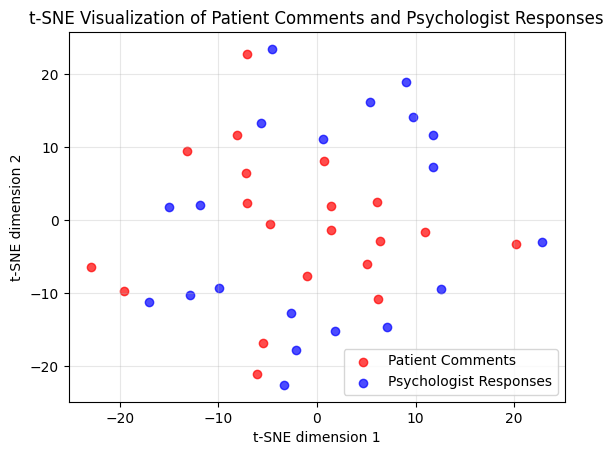

In [49]:
import matplotlib.pyplot as plt

# Plot points by label
patient_df = TSNE_vecs_df[TSNE_vecs_df['label'] == 'patient']
psyc_df = TSNE_vecs_df[TSNE_vecs_df['label'] == 'psycho']

plt.scatter(patient_df['x'], patient_df['y'], color='red', label='Patient Comments', alpha=0.7)
plt.scatter(psyc_df['x'], psyc_df['y'], color='blue', label='Psychologist Responses', alpha=0.7)

plt.title('t-SNE Visualization of Patient Comments and Psychologist Responses')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

There are no clear cluster's so far that we see.

However, if we think similarity we might see something different

In [63]:
mental_health['TSNE_similarity'] = [cosine_similarity(x, y) for x, y in zip(TSNE_vecs_df.loc[TSNE_vecs_df['label'] == 'patient',"vec"], TSNE_vecs_df.loc[TSNE_vecs_df['label'] == 'psycho',"vec"])]

In [64]:
mental_health['TSNE_similarity'].describe()

count    20.000000
mean      0.725537
std       0.478937
min      -0.726053
25%       0.765825
50%       0.966290
75%       0.993309
max       0.999464
Name: TSNE_similarity, dtype: float64

Note that the median patient-psycologist response is almost in the same direction, which is good. Only one had a opposite direction response

In [53]:
# Find indices of max and min TSNE_similarity
min_tsne_idx = mental_health['TSNE_similarity'].idxmin()
max_tsne_idx = mental_health['TSNE_similarity'].idxmax()

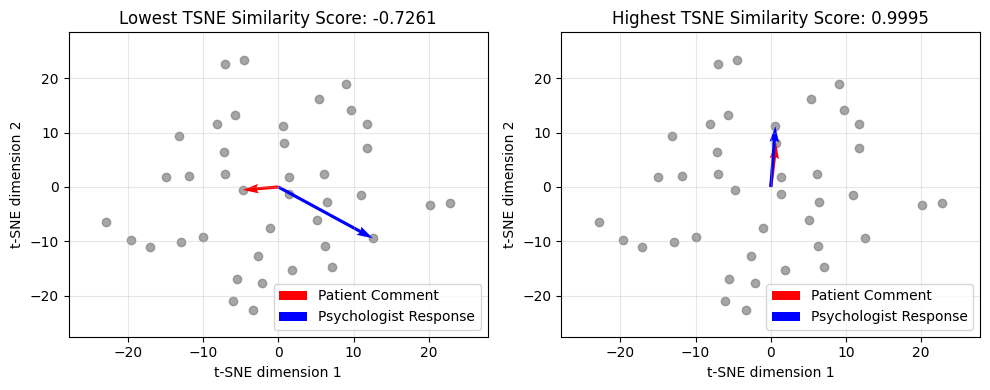

In [92]:
# Find indices of max and min TSNE_similarity
min_tsne_idx = mental_health['TSNE_similarity'].idxmin()
max_tsne_idx = mental_health['TSNE_similarity'].idxmax()

# Get corresponding indices in TSNE_vecs_df
min_idx_patient = mental_health.index.get_loc(min_tsne_idx)
min_idx_psych = min_idx_patient + len(vectors_patients)  # Offset to psychologist vectors
max_idx_patient = mental_health.index.get_loc(max_tsne_idx)
max_idx_psych = max_idx_patient + len(vectors_patients)  # Offset to psychologist vectors

# Get the corresponding TSNE coordinates from TSNE_vecs_df
min_patient = TSNE_vecs_df.iloc[min_idx_patient]['vec']
min_psyc = TSNE_vecs_df.iloc[min_idx_psych]['vec']
max_patient = TSNE_vecs_df.iloc[max_idx_patient]['vec']
max_psyc = TSNE_vecs_df.iloc[max_idx_psych]['vec']

# Get all coordinates for the background points
patient_x = TSNE_vecs_df[TSNE_vecs_df['label'] == 'patient']['x']
patient_y = TSNE_vecs_df[TSNE_vecs_df['label'] == 'patient']['y']
psyc_x = TSNE_vecs_df[TSNE_vecs_df['label'] == 'psycho']['x']
psyc_y = TSNE_vecs_df[TSNE_vecs_df['label'] == 'psycho']['y']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot for minimum similarity
axs[0].scatter(patient_x, patient_y, color='grey', alpha=0.7)
axs[0].scatter(psyc_x, psyc_y, color='grey', alpha=0.7)
axs[0].quiver(0, 0, min_patient[0], min_patient[1], angles='xy', scale_units='xy', scale=1, color='red', label='Patient Comment')
axs[0].quiver(0, 0, min_psyc[0], min_psyc[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Psychologist Response')
axs[0].set_title(f'Lowest TSNE Similarity Score: {mental_health["TSNE_similarity"].min():.4f}')

axs[0].set_xlabel('t-SNE dimension 1')
axs[0].set_ylabel('t-SNE dimension 2')
axs[0].grid(alpha=0.3)
axs[0].legend()

# Set reasonable limits based on the data range
x_min, x_max = TSNE_vecs_df['x'].min(), TSNE_vecs_df['x'].max()
y_min, y_max = TSNE_vecs_df['y'].min(), TSNE_vecs_df['y'].max()
margin = 5
axs[0].set_xlim(x_min - margin, x_max + margin)
axs[0].set_ylim(y_min - margin, y_max + margin)

# Plot for maximum similarity
axs[1].scatter(patient_x, patient_y, color='grey', alpha=0.7)
axs[1].scatter(psyc_x, psyc_y, color='grey', alpha=0.7)
axs[1].quiver(0, 0, max_patient[0], max_patient[1], angles='xy', scale_units='xy', scale=1, color='red', label='Patient Comment')
axs[1].quiver(0, 0, max_psyc[0], max_psyc[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Psychologist Response')
axs[1].set_title(f'Highest TSNE Similarity Score: {mental_health["TSNE_similarity"].max():.4f}')
axs[1].set_xlabel('t-SNE dimension 1')
axs[1].set_ylabel('t-SNE dimension 2')
axs[1].grid(alpha=0.3)
axs[1].legend()

# Use same limits for consistency
axs[1].set_xlim(x_min - margin, x_max + margin)
axs[1].set_ylim(y_min - margin, y_max + margin)

plt.tight_layout()
plt.show()

In [75]:
for ind in [min_tsne_idx, max_tsne_idx]:
    print(f"Similarity score: {mental_health.loc[ind]['TSNE_similarity']:.4f}")
    print("\nPatient comment:")
    print(mental_health.loc[ind]['patient_comment'])
    print("\nPsychologist response:")
    print(mental_health.loc[ind]['psyc_response'])
    print("\n" + "-"*80 + "\n")

Similarity score: -0.7261

Patient comment:
I've pretty much been on my own since day one, I'm a middle child of five, and I can't seem to put my trust in anyone. It took me four years to finally open up a little to my best friend. Every time I realize that I have feelings for someone, I freak out and never talk to them again. I really want some help.

Psychologist response:
One way to concentrate is that if your mind starts to wonder then remind yourself to bring your attention back.Start with short time spans of expecting yourself to concentrate.  You'll more likely succeed with concentrating with small time spans than longer ones.Once you start seeing your success, this will motivate you to try increasing the length to expect yourself to concentrate.The task of self-reminding is the same, whether for long or short time periods.Also, before starting this exercise ask your medical doctor if the problem can be related to a physical health problem.If there is, then have the possibility 

Now we can do the same with UMAP, which will give us a different vectors.

In [42]:
reducer = umap.UMAP(transform_seed=1337, random_state=7331)

In [79]:
vectors_patients = np.array([np.array(xi) for xi in mental_health['patient_USE_vecs']])
vectors_psycs = np.array([np.array(xi) for xi in mental_health['psyc_USE_vecs']])
lables = ["patient" for _ in range(len(vectors_patients))] + \
         ["psycho" for _ in range(len(vectors_psycs))]
vectors = np.concatenate((vectors_patients, vectors_psycs), axis=0)
fitted_vals = reducer.fit_transform(vectors)
psyc_UMAP_vecs = fitted_vals.tolist()

/Users/jjgecon/Library/CloudStorage/OneDrive-Personal/Work/GitHub Repos/NLP_starter/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [80]:
UMAP_vecs_df = pd.DataFrame(psyc_UMAP_vecs, columns=["x", "y"])
UMAP_vecs_df["label"] = lables
UMAP_vecs_df["vec"] = psyc_UMAP_vecs

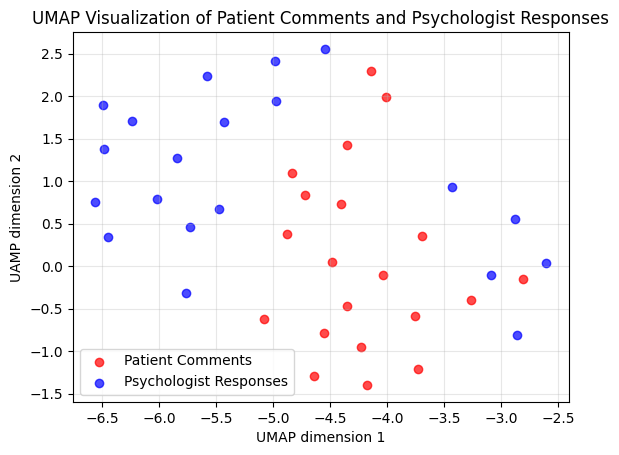

In [82]:
# Plot points by label
patient_df = UMAP_vecs_df[UMAP_vecs_df['label'] == 'patient']
psyc_df = UMAP_vecs_df[UMAP_vecs_df['label'] == 'psycho']

plt.scatter(patient_df['x'], patient_df['y'], color='red', label='Patient Comments', alpha=0.7)
plt.scatter(psyc_df['x'], psyc_df['y'], color='blue', label='Psychologist Responses', alpha=0.7)

plt.title('UMAP Visualization of Patient Comments and Psychologist Responses')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UAMP dimension 2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Notice how with this UMAP, we now can see two cluster's already forming from patients and psycologists

In [93]:
mental_health['UMAP_similarity'] = [cosine_similarity(x, y) for x, y in zip(UMAP_vecs_df.loc[UMAP_vecs_df['label'] == 'patient',"vec"], UMAP_vecs_df.loc[UMAP_vecs_df['label'] == 'psycho',"vec"])]

In [94]:
mental_health['UMAP_similarity'].describe()

count    20.000000
mean      0.971931
std       0.037328
min       0.874494
25%       0.947256
50%       0.992917
75%       0.998586
max       0.999995
Name: UMAP_similarity, dtype: float64

In this case almost all responces are good (in the cosine similarity sense).

Which measn that the algorithm that you use to get the latent space matters for the similarity calculations.